In [1]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup
from cryoS2Sdrop.predict import load_model


from pytorch_msssim import ssim
from torchmetrics.functional import peak_signal_noise_ratio, mean_squared_error
import torch

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from glob import glob
import os
import yaml
# from itables import init_notebook_mode
# init_notebook_mode(all_interactive=True)

PARENT_PATH = setup.PARENT_PATH

pd.options.display.float_format = "{:,.6f}".format
pd.set_option('display.max_columns', 50)

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
def standardize(X: torch.tensor):
    mean = X.mean()
    std = X.std()
    new_X = (X - mean) / std

    return new_X

def clip(X, low=0.005, high=0.995):
    # works with tensors =)
    return np.clip(X, np.quantile(X, low), np.quantile(X, high))

def scale(X):
    scaled = (X - X.min()) / (X.max() - X.min() + 1e-5)
    return scaled

def get_metrics(tomo_path, gt_tomo_path, use_deconv_data, clip_values):
    
    n2v_psnr, n2v_ssim_idx = None, None
    
    if use_deconv_data=='true':
        use_deconv_data=True
    elif use_deconv_data=='false':
        use_deconv_data=False
    
    if (tomo_path is not None) and (gt_tomo_path is not None):       
        try:
            gt_data = read_array(gt_tomo_path)
            gt_data = torch.tensor(gt_data).unsqueeze(0).unsqueeze(0)
            if clip_values:
                gt_data = clip(gt_data)
            gt_data = standardize(gt_data)

            name = tomo_path.split('/')[-1].replace('.mrc', '')

            if use_deconv_data:
                _type = 'deconv'
            else:
                _type = 'normal'

            n2v_pred_path = os.path.join(PARENT_PATH,
                                         "data/S2SDenoising/n2v_model_logs/%s/%s/%s_n2vDenoised.mrc" %(name, _type, name))
            # print(n2v_pred_path)

            n2v_data = read_array(n2v_pred_path)
            n2v_data = torch.tensor(n2v_data).unsqueeze(0).unsqueeze(0)
            if clip_values:
                n2v_data = clip(n2v_data)
            n2v_data = standardize(n2v_data)
            n2v_data = scale(n2v_data)
            gt_data = scale(gt_data)

            n2v_psnr = float(peak_signal_noise_ratio(n2v_data, gt_data, data_range=1))
            n2v_ssim_idx = float(ssim(n2v_data, gt_data, data_range=1))
            
        except OSError:
            pass

        
    return n2v_psnr, n2v_ssim_idx

def logdir_to_dataframe(logdir, clip_values, ignore_deconv=True):
    data_log = []
    keys = ['Version_comment', 'transform', 'full_tomo_psnr', 'full_tomo_ssim', 'baseline_psnr', 'baseline_ssim',
            'tomo_path', 'gt_tomo_path', 'use_deconv_as_target', 'predict_simRecon', 'use_deconv_data', 'p']
    
    all_logs = glob(logdir+'*/*.yaml')
    
    for yaml_logdir in all_logs:
        model = yaml_logdir.split('/')[-3]
        version = yaml_logdir.split('/')[-2]
        with open(yaml_logdir) as f:
            hparams = yaml.load(f, Loader=yaml.BaseLoader)
        
        if 'dataset' in hparams.keys():
            dataset = hparams['dataset']
            
        else:
            # yaml is stupid
            with open(yaml_logdir) as f:
                s = f.readlines()
                try:
                    dataloader = [x for x in s if 'Dataloader' in x][0]
                    dataset = dataloader.split('.')[-1].replace('\n', '').replace('\'', '')
                except:
                    dataset = 'Unknown'

        row_vals = [model, version, dataset, hparams['loss_fn']['alpha']]
        for k in keys:
            try:
                row_vals += [hparams[k]]
            except KeyError:
                row_vals += [None]
        data_log.append(row_vals)

    data_log = pd.DataFrame(data_log, columns=['model', 'version', 'dataset', 'TV_alpha']+keys)
    data_log = data_log.sort_values(['model', 'version'])
    
    if ignore_deconv:
        baseline_metrics = data_log[['tomo_path', 'gt_tomo_path', 'use_deconv_data']].apply(lambda x: 
                                                                                            get_metrics(x[0], x[1], 'false', clip_values),
                                                                                            axis=1)
    else:
        baseline_metrics = data_log[['tomo_path', 'gt_tomo_path', 'use_deconv_data']].apply(lambda x: 
                                                                                            get_metrics(x[0], x[1], x[2], clip_values),
                                                                                            axis=1)
    data_log['n2v_psnr'], data_log['n2v_ssim'] = zip(*baseline_metrics) 
    data_log[['full_tomo_psnr', 'full_tomo_ssim']] = data_log[['full_tomo_psnr', 'full_tomo_ssim']].astype(float)
    data_log[['baseline_psnr', 'baseline_ssim']] = data_log[['baseline_psnr', 'baseline_ssim']].astype(float)
    
    data_log['baseline_psnr_best'] = data_log.baseline_psnr.max()
    data_log['baseline_ssim_best'] = data_log.baseline_ssim.max()

    tomo_path = data_log.tomo_path.map(lambda x: x.split('/')[-1] if x is not None else x)
    gt_tomo_path = data_log.gt_tomo_path#.map(lambda x: x.split('/')[-1] if x is not None else x)

    # data_log.drop(['tomo_path', 'gt_tomo_path'], axis=1, inplace=True)
    data_log['tomo_path'], data_log['gt_tomo_path'] = [tomo_path, gt_tomo_path]
    
    _vals = 100*data_log[['full_tomo_ssim', 'n2v_ssim']].apply(lambda x: (x-data_log['baseline_ssim_best'])/data_log['baseline_ssim_best'])
    data_log['ssim_vs_baseline'], data_log['n2v_ssim_vs_baseline'] = zip(*_vals.values)

    _vals = 100*data_log[['full_tomo_psnr', 'n2v_psnr']].apply(lambda x: (x-data_log['baseline_psnr_best'])/data_log['baseline_psnr_best'])
    data_log['psnr_vs_baseline'], data_log['n2v_psnr_vs_baseline'] = zip(*_vals.values)
    
    return data_log

def get_best_version(data_log, metric):
    if metric=='psnr':
        _best = data_log[data_log.psnr_vs_baseline==data_log.psnr_vs_baseline.max()]
        _worst = data_log[data_log.psnr_vs_baseline==data_log.psnr_vs_baseline.min()]
    if metric=='ssim':
        _best = data_log[data_log.ssim_vs_baseline==data_log.ssim_vs_baseline.max()]
        _worst = data_log[data_log.ssim_vs_baseline==data_log.ssim_vs_baseline.min()]
        
    best_version = _best.version.values[0]
    tomo_name = _best.tomo_path.values[0].replace('.mrc', '')
    logdir = 'data/S2SDenoising/model_logs/%s/realBernoulli_convolved_comparison/' %tomo_name
    logdir = os.path.join(PARENT_PATH, logdir)  
    pred_tomo_path = logdir+'%s/%s_s2sDenoised.mrc' %(best_version, tomo_name)
    gt_tomo_path = _best.gt_tomo_path.values[0]
    
    worst_version = _worst.version.values[0]
    tomo_name2 = _worst.tomo_path.values[0].replace('.mrc', '')
    logdir = 'data/S2SDenoising/model_logs/%s/realBernoulli_convolved_comparison/' %tomo_name2
    logdir = os.path.join(PARENT_PATH, logdir) 
    pred_tomo_path2 = logdir+'%s/%s_s2sDenoised.mrc' %(worst_version, tomo_name2)
    
    print('Best version: ', pred_tomo_path)
    print('GT file: ', gt_tomo_path)
    print('Best %s value: ' %metric, _best['full_tomo_%s' %metric])
    print('Worst %s value: ' %metric, _worst['full_tomo_%s' %metric])
    
    best = read_array(pred_tomo_path)
    gt = read_array(gt_tomo_path)
    worst = read_array(pred_tomo_path2)
    
    return best, gt, worst

# Model 4

In [3]:
tomo_list = ['shrec2021_model4_dummy']

data_log = []

for tomo in tomo_list:
    logdir = 'data/S2SDenoising/model_logs/%s/realBernoulli_convolved_comparison/' %tomo
    logdir = os.path.join(PARENT_PATH, logdir)

    _data_log = logdir_to_dataframe(logdir, clip_values=True, ignore_deconv=False)
    data_log.append(_data_log)

data_log = pd.concat(data_log)
data_log

model    version            dataset TV_alpha  \
0  realBernoulli_convolved_comparison  version_0  singleCET_dataset        0   
1  realBernoulli_convolved_comparison  version_1  singleCET_dataset        0   
3  realBernoulli_convolved_comparison  version_2  singleCET_dataset        0   
2  realBernoulli_convolved_comparison  version_3  singleCET_dataset        0   

         Version_comment     transform  full_tomo_psnr  full_tomo_ssim  \
0              Bernoulli  {'p': '0.5'}        6.016479       -0.039001   
1  Deconvolved Bernoulli  {'p': '0.5'}        5.192185       -0.056545   
3              Bernoulli  {'p': '0.5'}        5.751411       -0.047679   
2  Deconvolved Bernoulli  {'p': '0.5'}        4.963487       -0.059713   

   baseline_psnr  baseline_ssim                   tomo_path  \
0       5.503306      -0.038987  shrec2021_model4_dummy.mrc   
1       5.213845      -0.053055  shrec2021_model4_dummy.mrc   
3       5.503306      -0.038987  shrec2021_model4_dummy.mrc   
2       5.213845      -0.053055  shrec2021_model4_dummy.mrc   

                                        gt_tomo_path use_deconv_as_target  \
0  /home/ubuntu/Thesis/data/S2SDenoising/dummy_to...                 null   
1  /home/ubuntu/Thesis/data/S2SDenoising/dummy_to...                 null   
3  /home/ubuntu/Thesis/data/S2SDenoising/dummy_to...                 null   
2  /home/ubuntu/Thesis/data/S2SDenoising/dummy_to...                 null   

  predict_simRecon use_deconv_data    p  n2v_psnr  n2v_ssim  \
0             null           false  0.3  5.716530 -0.037105   
1             null            true  0.3  4.858604 -0.042476   
3             null           false  0.7  5.716530 -0.037105   
2             null            true  0.7  4.858604 -0.042476   

   baseline_psnr_best  baseline_ssim_best  ssim_vs_baseline  \
0            5.503306           -0.038987          0.034781   
1            5.503306           -0.038987         45.033288   
3            5.503306           -0.038987         22.293346   
2            5.503306           -0.038987         53.159546   

   n2v_ssim_vs_baseline  psnr_vs_baseline  n2v_psnr_vs_baseline  
0             -4.828497          9.324806              3.874470  
1              8.947729         -5.653347            -11.714811  
3             -4.828497          4.508282              3.874470  
2              8.947729         -9.808998            -11.714811

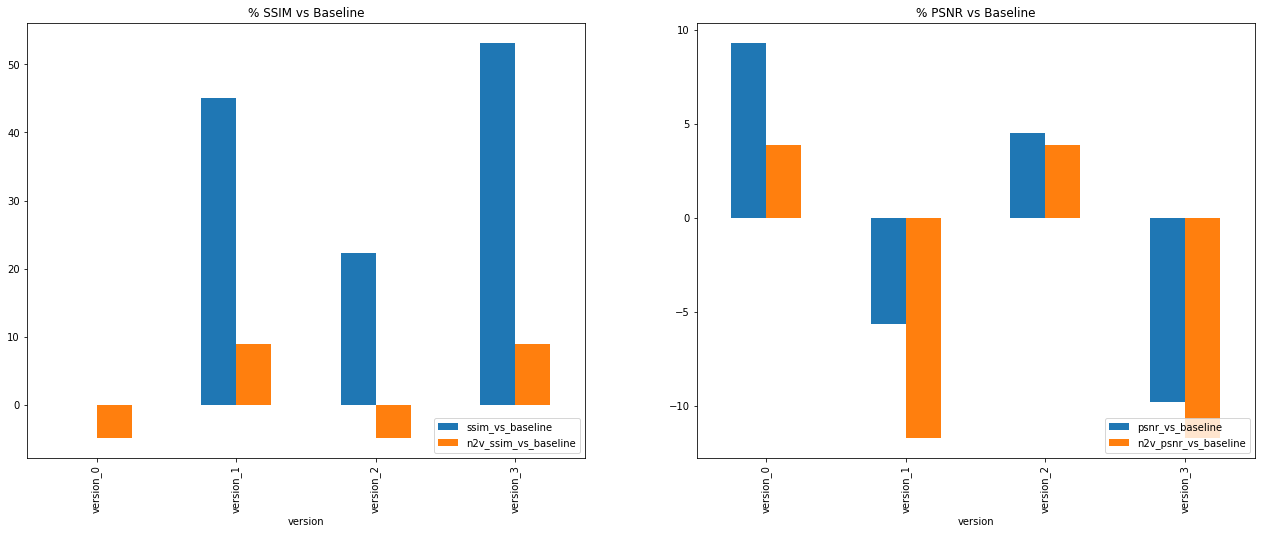

In [4]:
######### Gains wrt baseline (input)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

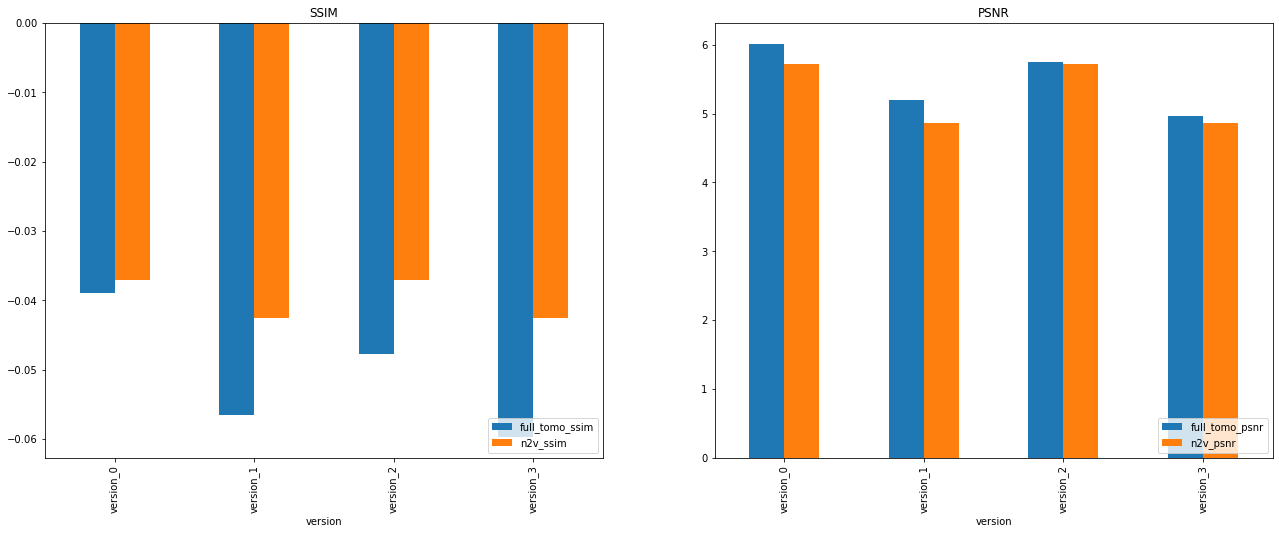

In [5]:
######### Values
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'full_tomo_ssim', 'n2v_ssim']].plot.bar(x='version', ax=ax0)
ax0.set_title('SSIM')
ax0.legend(loc='lower right')

data_log[['version', 'full_tomo_psnr', 'n2v_psnr']].plot.bar(x='version', ax=ax1)
ax1.set_title('PSNR')
ax1.legend(loc='lower right')

Best version:  /home/ubuntu/Thesis/data/S2SDenoising/model_logs/shrec2021_model4_dummy/realBernoulli_convolved_comparison/version_3/shrec2021_model4_dummy_s2sDenoised.mrc
GT file:  /home/ubuntu/Thesis/data/S2SDenoising/dummy_tomograms/shrec2021_model4_gtDummy.mrc
Best ssim value:  2   -0.059713
Name: full_tomo_ssim, dtype: float64
Worst ssim value:  0   -0.039001
Name: full_tomo_ssim, dtype: float64


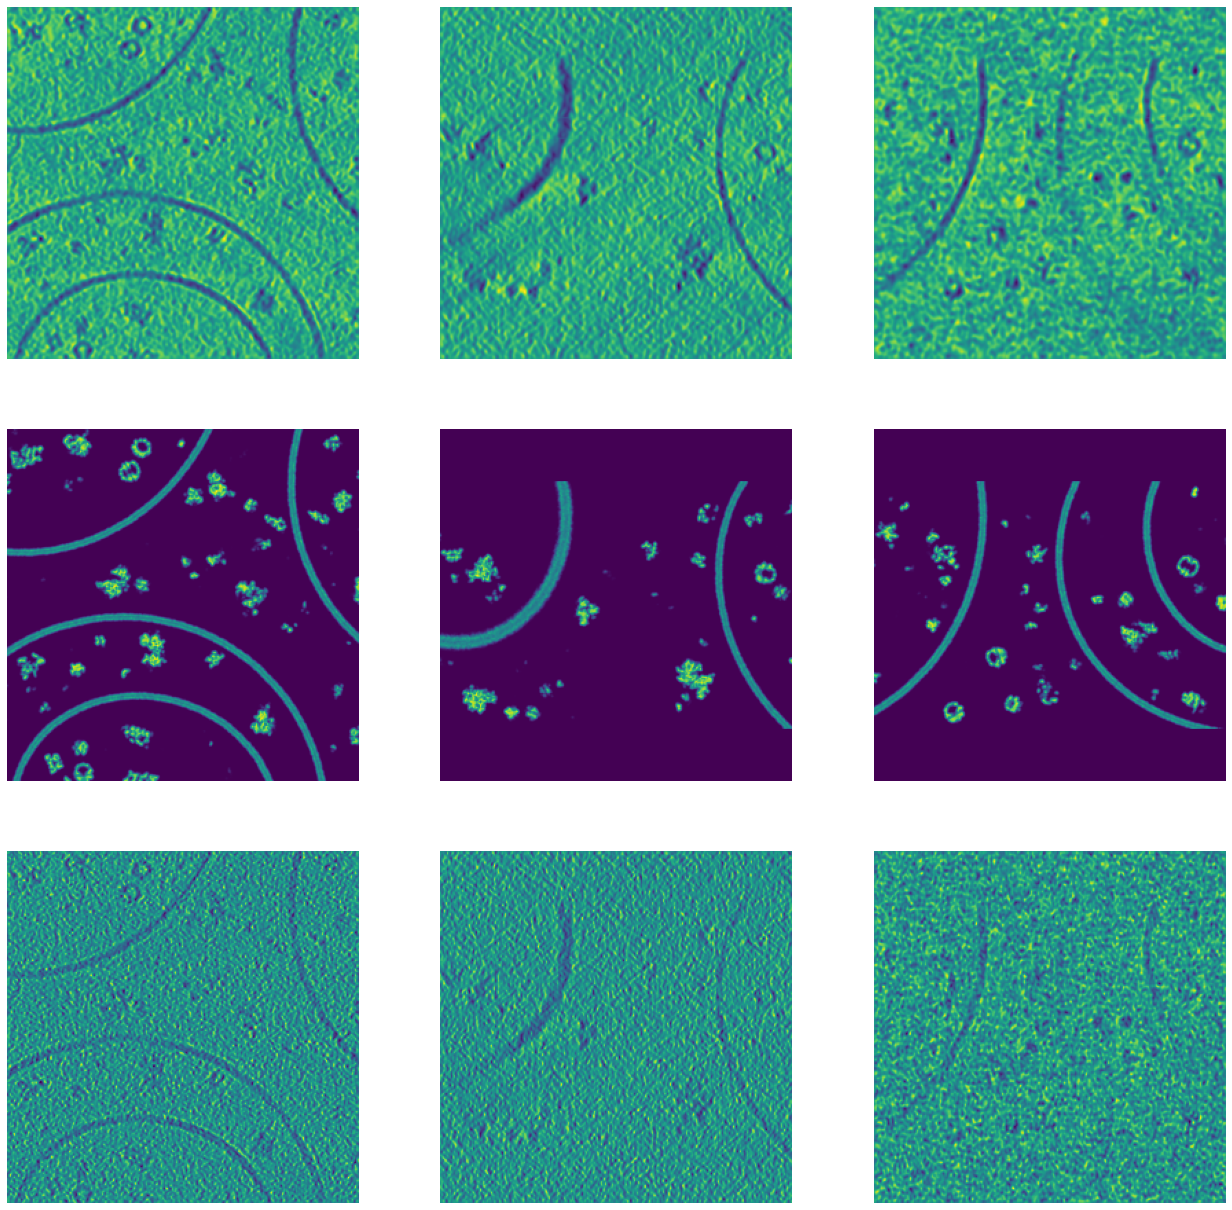

In [6]:
best, gt, worst = get_best_version(data_log, 'ssim')
best, gt, worst = scale(best), scale(gt), scale(worst)

fig, (ax0, ax1, ax2) = plt.subplots(3, 3, figsize=(22, 22))
list(map(lambda axi: axi.set_axis_off(), np.array([ax0, ax1, ax2]).ravel()))
# zidx, yidx, xidx = np.array(best.shape)//2
zidx, yidx, xidx = np.array(best.shape)//4

ax0[0].imshow(best[zidx])
ax0[1].imshow(best[:, yidx, :])
ax0[2].imshow(best[:, :, xidx])
ax1[0].imshow(gt[zidx])
ax1[1].imshow(gt[:, yidx, :])
ax1[2].imshow(gt[:, :, xidx])
ax2[0].imshow(worst[zidx])
ax2[1].imshow(worst[:, yidx, :])
ax2[2].imshow(worst[:, :, xidx])

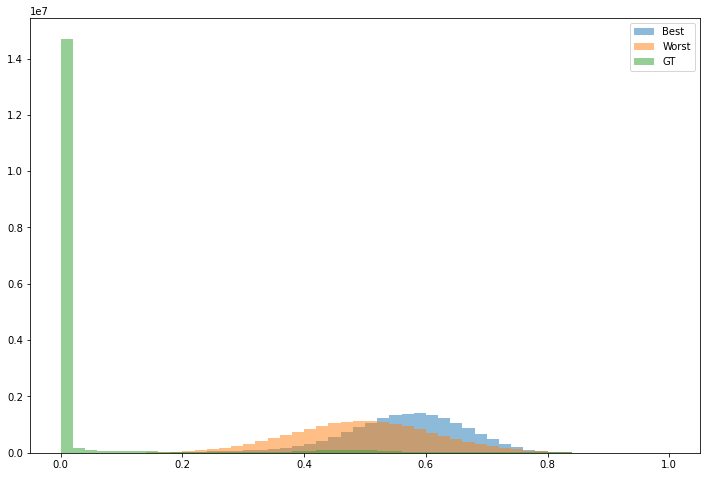

In [7]:
plt.figure(figsize=(12, 8))
plt.hist(best.flatten(),alpha=0.5, label="Best", bins=50)
plt.hist(worst.flatten(),alpha=0.5, label="Worst", bins=50)
plt.hist(gt.flatten(), alpha=0.5, label="GT", bins=50)
plt.legend()

In [8]:
X = torch.tensor(scale(best[zidx])).unsqueeze(0).unsqueeze(0)
Y = torch.tensor(scale(gt[zidx])).unsqueeze(0).unsqueeze(0)

ssim_best = float(ssim(X, Y, data_range=1))

X = torch.tensor(scale(worst[zidx])).unsqueeze(0).unsqueeze(0)
Y = torch.tensor(scale(gt[zidx])).unsqueeze(0).unsqueeze(0)

ssim_worst = float(ssim(X, Y, data_range=1))

print(ssim_best, ssim_worst)

-0.11132834106683731 -0.07185060530900955


In [9]:
X = torch.tensor(scale(best[:, yidx, :])).unsqueeze(0).unsqueeze(0)
Y = torch.tensor(scale(gt[:, yidx, :])).unsqueeze(0).unsqueeze(0)

ssim_best = float(ssim(X, Y, data_range=1))

X = torch.tensor(scale(worst[:, yidx, :])).unsqueeze(0).unsqueeze(0)

ssim_worst = float(ssim(X, Y, data_range=1))

print(ssim_best, ssim_worst)

-0.05014598369598389 -0.03152674436569214


# Model 2

In [10]:
tomo_list = ['shrec2021_model2_dummy']

data_log = []

for tomo in tomo_list:
    logdir = 'data/S2SDenoising/model_logs/%s/realBernoulli_convolved_comparison/' %tomo
    logdir = os.path.join(PARENT_PATH, logdir)

    _data_log = logdir_to_dataframe(logdir, clip_values=True, ignore_deconv=False)
    data_log.append(_data_log)

data_log = pd.concat(data_log)
data_log

model    version            dataset TV_alpha  \
0  realBernoulli_convolved_comparison  version_0  singleCET_dataset        0   
1  realBernoulli_convolved_comparison  version_1  singleCET_dataset        0   
3  realBernoulli_convolved_comparison  version_2  singleCET_dataset        0   
2  realBernoulli_convolved_comparison  version_3  singleCET_dataset        0   

         Version_comment     transform  full_tomo_psnr  full_tomo_ssim  \
0              Bernoulli  {'p': '0.5'}        5.836009       -0.026475   
1  Deconvolved Bernoulli  {'p': '0.5'}        5.132121       -0.024892   
3              Bernoulli  {'p': '0.5'}        4.996282       -0.024221   
2  Deconvolved Bernoulli  {'p': '0.5'}        5.111185       -0.022567   

   baseline_psnr  baseline_ssim                   tomo_path  \
0       5.453989      -0.028081  shrec2021_model2_dummy.mrc   
1       5.384302      -0.024586  shrec2021_model2_dummy.mrc   
3       5.453989      -0.028081  shrec2021_model2_dummy.mrc   
2       5.384302      -0.024586  shrec2021_model2_dummy.mrc   

                                        gt_tomo_path use_deconv_as_target  \
0  /home/ubuntu/Thesis/data/S2SDenoising/dummy_to...                 null   
1  /home/ubuntu/Thesis/data/S2SDenoising/dummy_to...                 null   
3  /home/ubuntu/Thesis/data/S2SDenoising/dummy_to...                 null   
2  /home/ubuntu/Thesis/data/S2SDenoising/dummy_to...                 null   

  predict_simRecon use_deconv_data    p  n2v_psnr  n2v_ssim  \
0             null           false  0.3  5.682079 -0.031841   
1             null            true  0.3  5.681387 -0.028839   
3             null           false  0.7  5.682079 -0.031841   
2             null            true  0.7  5.681387 -0.028839   

   baseline_psnr_best  baseline_ssim_best  ssim_vs_baseline  \
0            5.453989           -0.024586          7.684182   
1            5.453989           -0.024586          1.246379   
3            5.453989           -0.024586         -1.485251   
2            5.453989           -0.024586         -8.212254   

   n2v_ssim_vs_baseline  psnr_vs_baseline  n2v_psnr_vs_baseline  
0             29.508153          7.004424              4.182091  
1             17.297071         -5.901506              4.169396  
3             29.508153         -8.392151              4.182091  
2             17.297071         -6.285372              4.169396

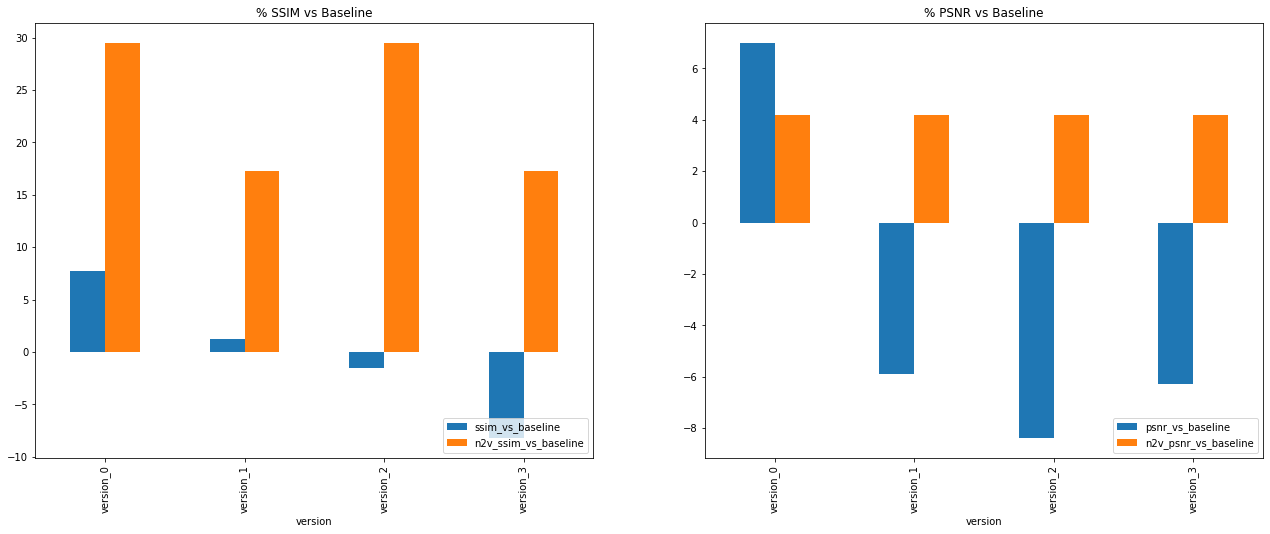

In [11]:
######### Gains wrt baseline (input)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'ssim_vs_baseline', 'n2v_ssim_vs_baseline']].plot.bar(x='version', ax=ax0)
ax0.set_title('% SSIM vs Baseline')
ax0.legend(loc='lower right')

data_log[['version', 'psnr_vs_baseline', 'n2v_psnr_vs_baseline']].plot.bar(x='version', ax=ax1)
ax1.set_title('% PSNR vs Baseline')
ax1.legend(loc='lower right')

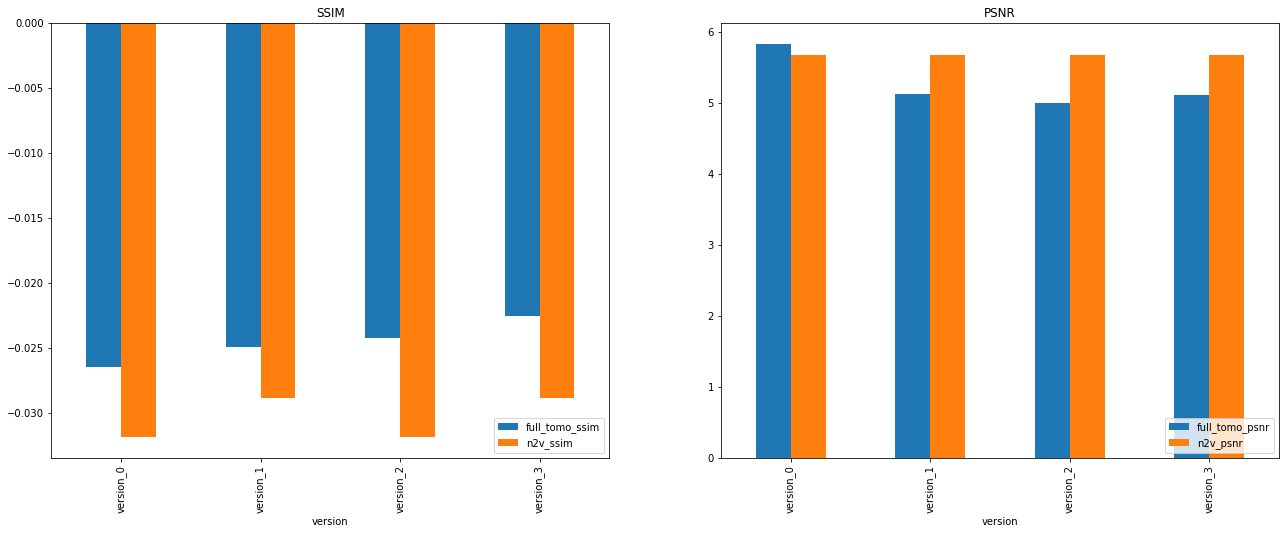

In [12]:
######### Values
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))
data_log[['version', 'full_tomo_ssim', 'n2v_ssim']].plot.bar(x='version', ax=ax0)
ax0.set_title('SSIM')
ax0.legend(loc='lower right')

data_log[['version', 'full_tomo_psnr', 'n2v_psnr']].plot.bar(x='version', ax=ax1)
ax1.set_title('PSNR')
ax1.legend(loc='lower right')

Best version:  /home/ubuntu/Thesis/data/S2SDenoising/model_logs/shrec2021_model2_dummy/realBernoulli_convolved_comparison/version_0/shrec2021_model2_dummy_s2sDenoised.mrc
GT file:  /home/ubuntu/Thesis/data/S2SDenoising/dummy_tomograms/shrec2021_model2_gtDummy.mrc
Best ssim value:  0   -0.026475
Name: full_tomo_ssim, dtype: float64
Worst ssim value:  2   -0.022567
Name: full_tomo_ssim, dtype: float64


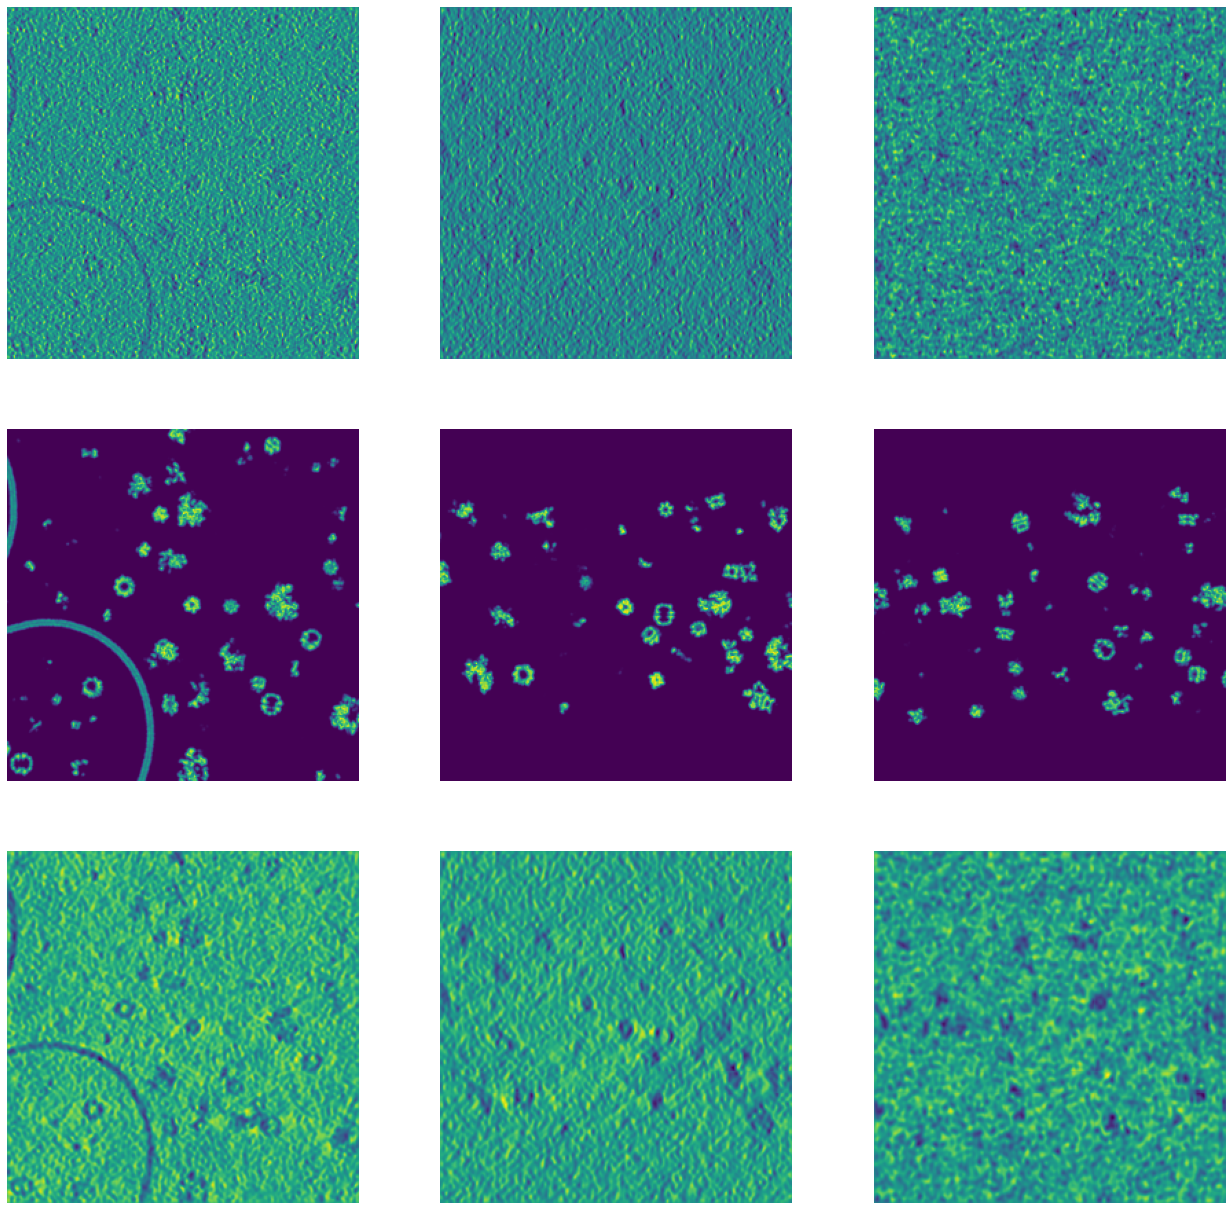

In [13]:
best, gt, worst = get_best_version(data_log, 'ssim')
best, gt, worst = scale(best), scale(gt), scale(worst)

fig, (ax0, ax1, ax2) = plt.subplots(3, 3, figsize=(22, 22))
list(map(lambda axi: axi.set_axis_off(), np.array([ax0, ax1, ax2]).ravel()))
zidx, yidx, xidx = np.array(best.shape)//2
# zidx, yidx, xidx = np.array(best.shape)//4

ax0[0].imshow(best[zidx])
ax0[1].imshow(best[:, yidx, :])
ax0[2].imshow(best[:, :, xidx])
ax1[0].imshow(gt[zidx])
ax1[1].imshow(gt[:, yidx, :])
ax1[2].imshow(gt[:, :, xidx])
ax2[0].imshow(worst[zidx])
ax2[1].imshow(worst[:, yidx, :])
ax2[2].imshow(worst[:, :, xidx])

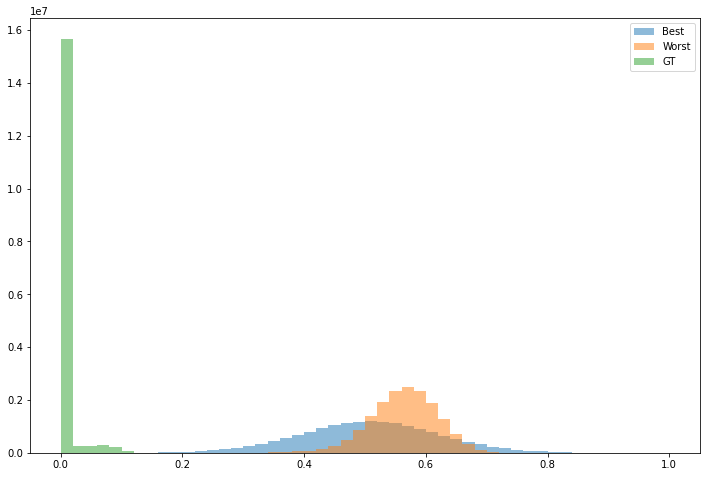

In [14]:
plt.figure(figsize=(12, 8))
plt.hist(best.flatten(),alpha=0.5, label="Best", bins=50)
plt.hist(worst.flatten(),alpha=0.5, label="Worst", bins=50)
plt.hist(gt.flatten(), alpha=0.5, label="GT", bins=50)
plt.legend()

In [15]:
X = torch.tensor(scale(best[zidx])).unsqueeze(0).unsqueeze(0)
Y = torch.tensor(scale(gt[zidx])).unsqueeze(0).unsqueeze(0)

ssim_best = float(ssim(X, Y, data_range=1))

X = torch.tensor(scale(worst[zidx])).unsqueeze(0).unsqueeze(0)
Y = torch.tensor(scale(gt[zidx])).unsqueeze(0).unsqueeze(0)

ssim_worst = float(ssim(X, Y, data_range=1))

print(ssim_best, ssim_worst)

-0.04455157369375229 -0.06257756054401398


In [16]:
X = torch.tensor(scale(best[:, yidx, :])).unsqueeze(0).unsqueeze(0)
Y = torch.tensor(scale(gt[:, yidx, :])).unsqueeze(0).unsqueeze(0)

ssim_best = float(ssim(X, Y, data_range=1))

X = torch.tensor(scale(worst[:, yidx, :])).unsqueeze(0).unsqueeze(0)

ssim_worst = float(ssim(X, Y, data_range=1))

print(ssim_best, ssim_worst)

-0.02570320852100849 -0.03533724322915077
